In [1]:
import pickle
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.display import HTML, display

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from theano import shared
import theano.tensor as tt
import pymc3 as pm
from tqdm import tqdm

import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo
from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature
from pymc_utils import lasso_regression, hs_regression
from pymc_utils import plot_fits_w_estimates

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
display(HTML("<style>.container{width: 90% !important}</style>"))

In [3]:
df_aphy_wi = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_PolyFeatures_SWF.pkl')

In [4]:
df_aphy_wi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Columns: 142 entries, sin_doy_s to aphy670
dtypes: float64(142)
memory usage: 179.8 KB


In [5]:
df_aphy_wi['log10_aphy411'] = np.log10(df_aphy_wi.aphy411)
df_aphy_wi['log10_aphy443'] = np.log10(df_aphy_wi.aphy443)
df_aphy_wi['log10_aphy489'] = np.log10(df_aphy_wi.aphy489)
df_aphy_wi['log10_aphy510'] = np.log10(df_aphy_wi.aphy510)
df_aphy_wi['log10_aphy555'] = np.log10(df_aphy_wi.aphy555)
df_aphy_wi['log10_aphy670'] = np.log10(df_aphy_wi.aphy670)

In [6]:
aphys = df_aphy_wi.filter(regex='^aphy').columns
df_aphy_wi.drop(aphys, axis=1, inplace=True)

In [7]:
df_aphy_wi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Columns: 142 entries, sin_doy_s to log10_aphy670
dtypes: float64(142)
memory usage: 179.8 KB


In [8]:
def PlotHeatMap(df, ax=None,):
    if ax is None:
        _, ax = pl.subplots(figsize=(20, 20))
    dfc = df.corr().iloc[1:, :-1]
    heatmap(dfc, vmin=-1, vmax=1, cmap=cmo.balance_r, annot=True, annot_kws={'fontsize': 13},
            ax=ax, mask=np.triu(np.ones([dfc.shape[1]]*2), k=1), fmt='.1f')
    ax.set_facecolor('k')
    return ax


def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')


def evaluate_model(model,  y_train_, y_test_, ax1_title=None, ax2_title=None, ax3_title=None,):
    f = pl.figure(figsize=(15, 15))
    ax1 = pl.subplot2grid((2, 2), (0, 0))
    ax2 = pl.subplot2grid((2, 2), (0, 1))
    ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2)
    X_shared.set_value(X_s_train.values)
    ppc_train_ = model.predict(likelihood_name='likelihood' )
    model.plot_model_fits(y_train_, ppc_train_, loss_metric='mae',
                          ax=ax1, title=ax1_title, );
    X_shared.set_value(X_s_test.values)
    ppc_test_ = model.predict(likelihood_name='likelihood')
    model.plot_model_fits(y_test_, ppc_test_, loss_metric='mae',
                          ax=ax2, title=ax2_title, );
    plot_fits_w_estimates(y_test_, ppc_test_, ax=ax3)
    ax3.set_title(ax3_title)
    return f, ppc_train_, ppc_test_

### <u>Modeling</u>

Below the smaller dataset (no interactions features one entry where all PC's are NaNs.
I just drop that row for now. To impute the missing predictors is a bit more complicated than when predicted values are missing.

In [9]:
feat_beg = 'sin_doy_s'
feat_end_ni = 'PC5_s PC6_s'
X_s = df_aphy_wi.loc[:, feat_beg :feat_end_ni]
y = df_aphy_wi.loc[:, 'log10_aphy411':]

In [10]:
feature_labels=df_aphy_wi.loc[:,:feat_end_ni].columns.tolist()

In [11]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

### A$\phi$ 411

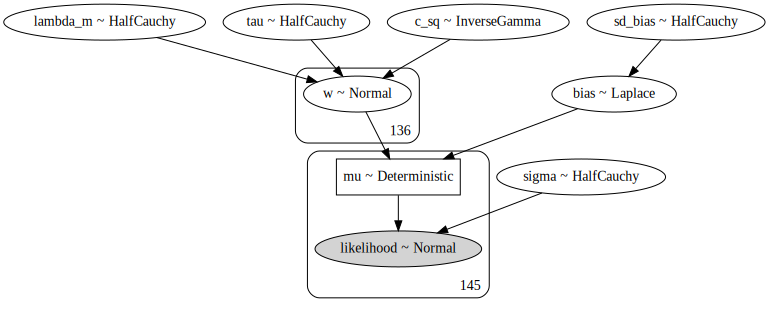

In [12]:
X_shared = shared(X_s_train.values)
m_hshoe_411 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy411, model_name='hshoe_aphy411_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_411.show_model()

In [13]:
m_hshoe_411.fit(tune=7000, cores=1, chains=2, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
100%|██████████| 9000/9000 [02:52<00:00, 52.27it/s]


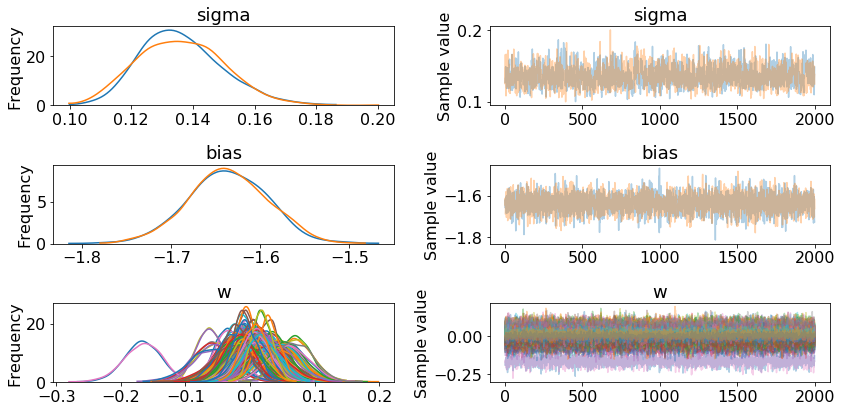

In [14]:
m_hshoe_411.evaluate_fit(['sigma',  'bias', 'w']);

In [15]:
significant_features = subset_significant_feature(m_hshoe_411.trace_, feature_labels, vars_=['w'])

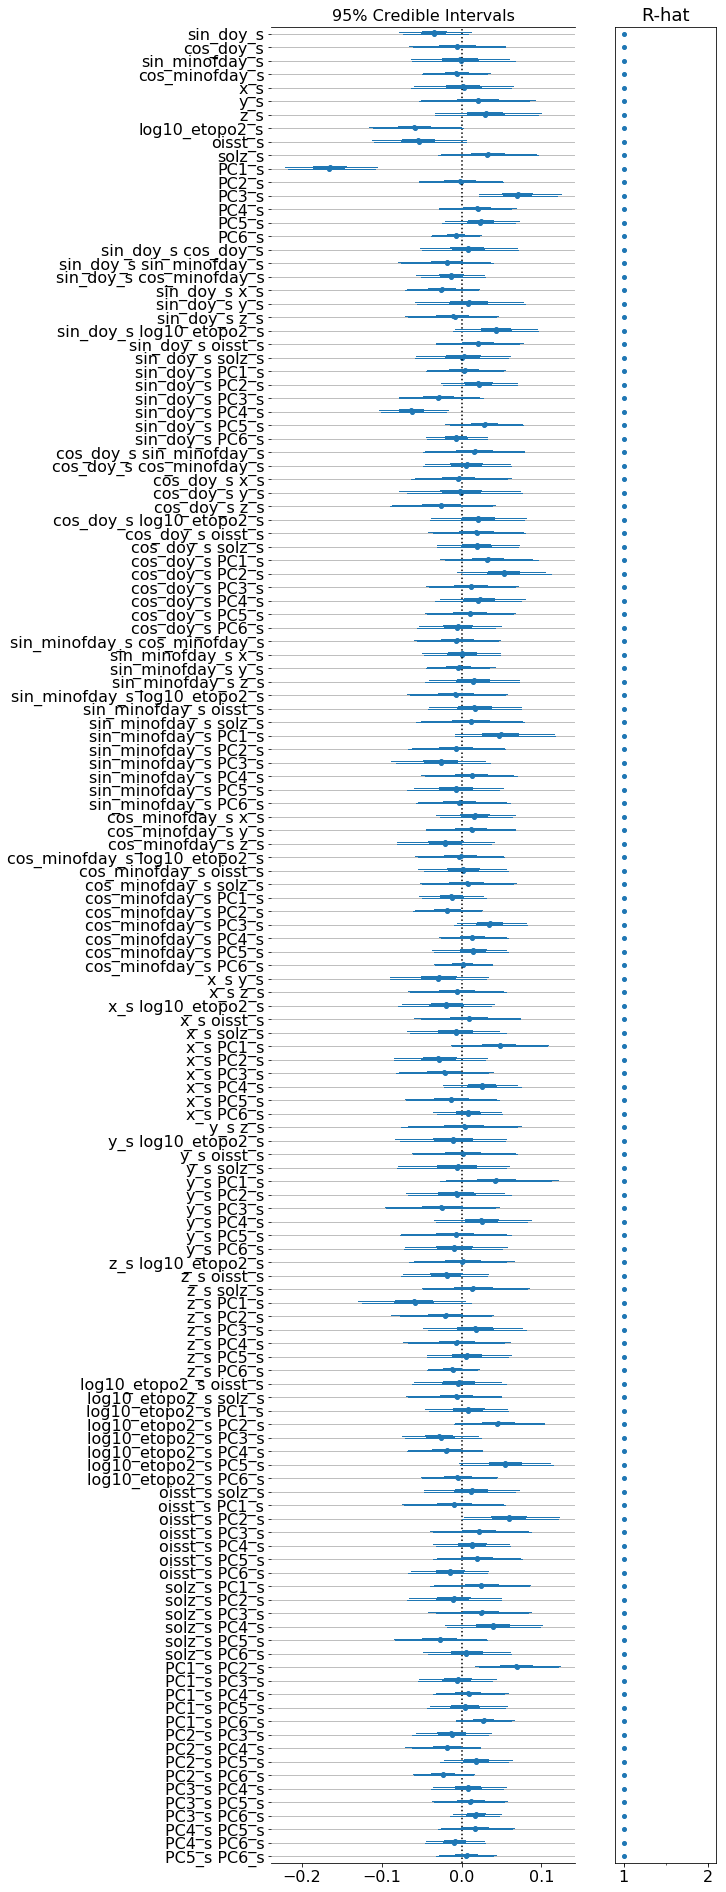

In [16]:
m_hshoe_411.show_forest(['w'], feat_labels=feature_labels);
f = pl.gcf()
f.set_figheight(30)
f.set_figwidth(12)
#f.savefig('./figJar/APHI411_foresplot.png', dpi=300, format='png')

100%|██████████| 2000/2000 [00:01<00:00, 1339.19it/s]


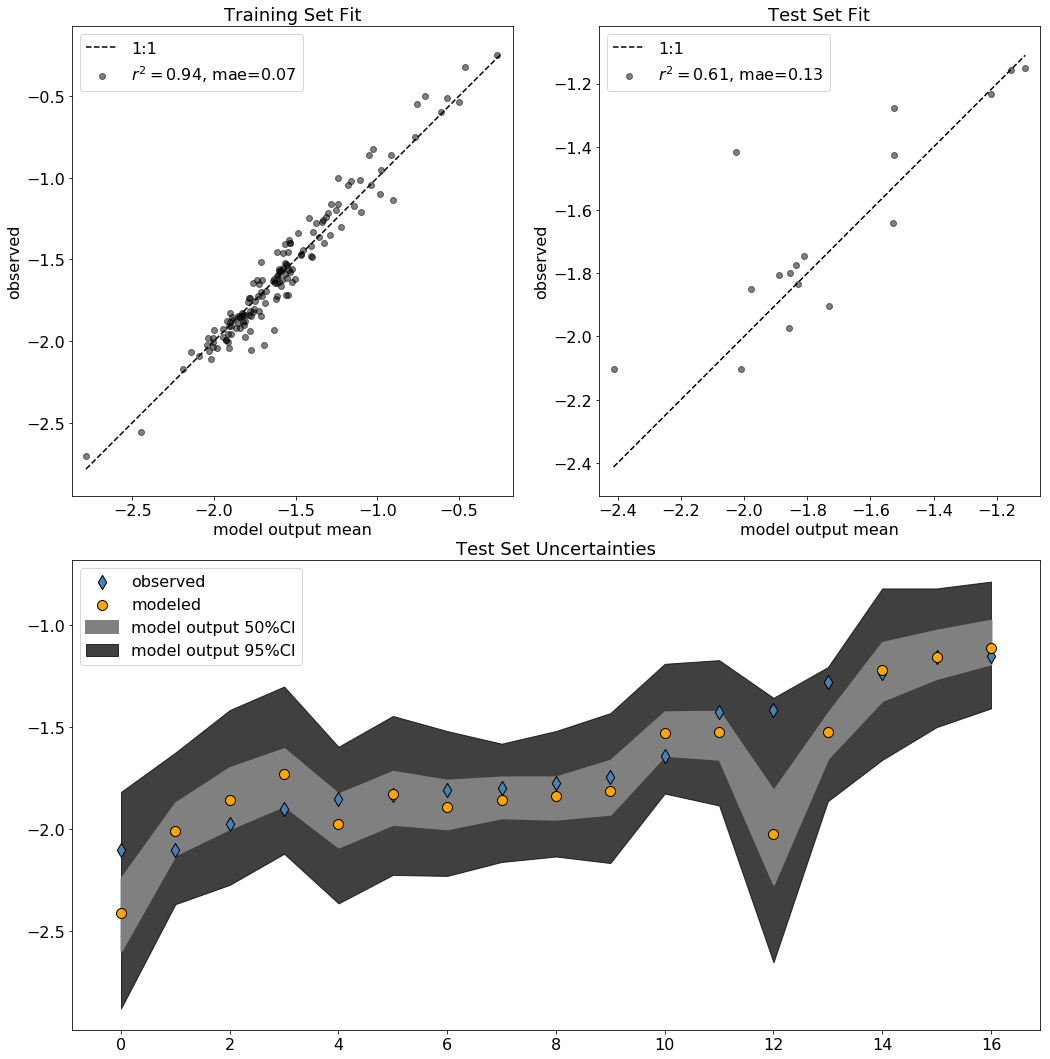

In [17]:
f, ppc_train_411, ppc_test_411 = evaluate_model(m_hshoe_411, y_train.log10_aphy411, y_test.log10_aphy411)
f.get_axes()[0].set_title('Training Set Fit');
f.get_axes()[1].set_title('Test Set Fit');
f.get_axes()[2].set_title('Test Set Uncertainties');

### A$\phi$ 443

In [18]:
X_shared = shared(X_s_train.values)
m_hshoe_443 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy443, model_name='hshoe_aphy443_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_443.fit(tune=7000, cores=1, chains=2, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
100%|██████████| 9000/9000 [03:14<00:00, 46.38it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


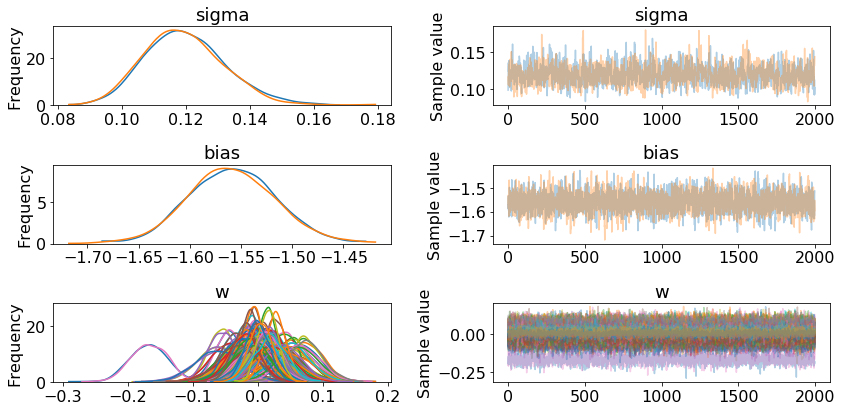

In [19]:
m_hshoe_443.evaluate_fit(['sigma',  'bias', 'w']);

100%|██████████| 2000/2000 [00:01<00:00, 1151.09it/s]


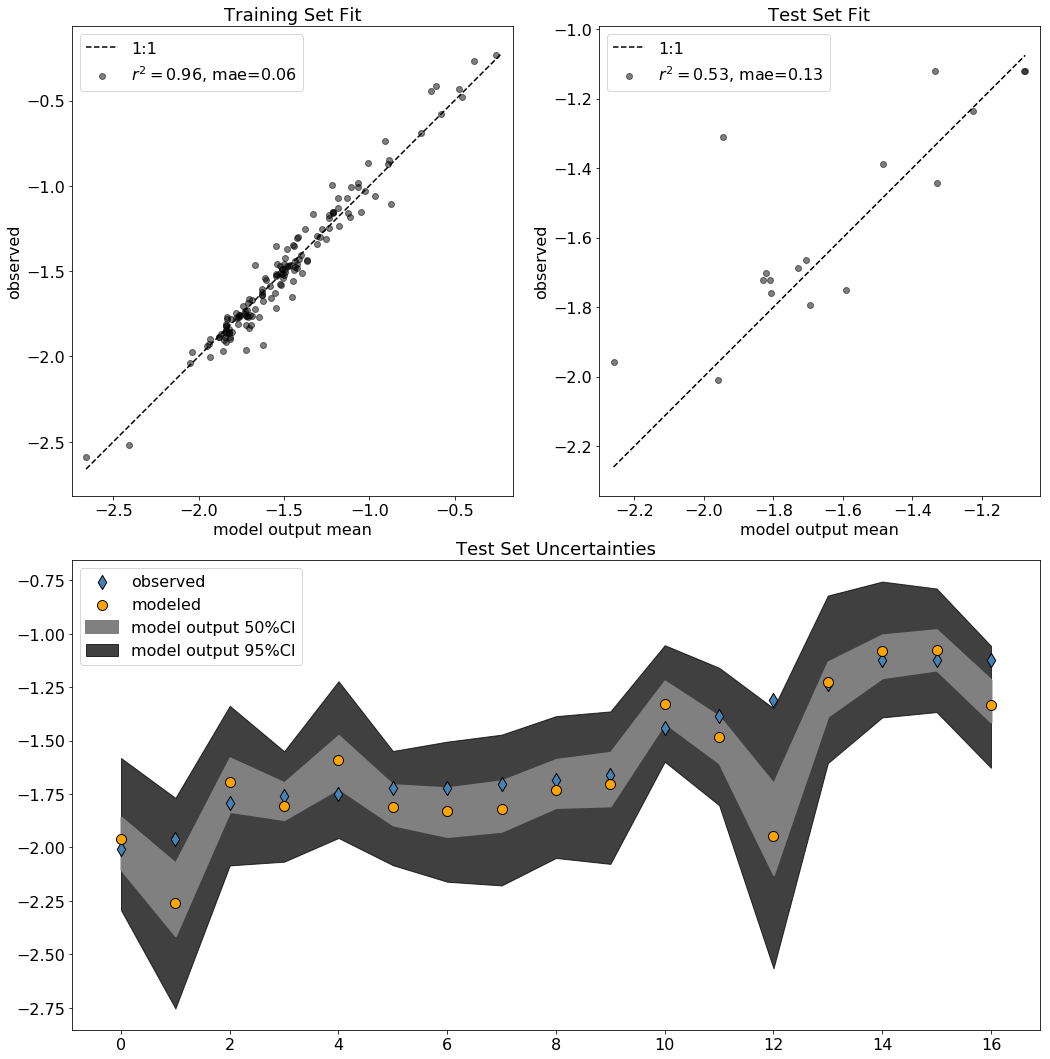

In [20]:
f, ppc_train_443, ppc_test_443 = evaluate_model(m_hshoe_443, y_train.log10_aphy443, y_test.log10_aphy443)
f.get_axes()[0].set_title('Training Set Fit');
f.get_axes()[1].set_title('Test Set Fit');
f.get_axes()[2].set_title('Test Set Uncertainties');

### A$\phi$ 489

In [21]:
X_shared = shared(X_s_train.values)
m_hshoe_489 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy489, model_name='hshoe_aphy489_',
                        ylabel='likelihood', regularized=True)
m_hshoe_489.fit(tune=7000, cores=1, chains=2, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
100%|██████████| 9000/9000 [17:53<00:00,  8.38it/s]


In [30]:
m_hshoe_489.model.name = 'hshoe_aphy489_wi'
m_hshoe_510.model.name = 'hshoe_aphy510_wi'
m_hshoe_555.model.name = 'hshoe_aphy555_wi'
m_hshoe_670.model.name = 'hshoe_aphy670_wi'

100%|██████████| 2000/2000 [00:02<00:00, 926.64it/s]


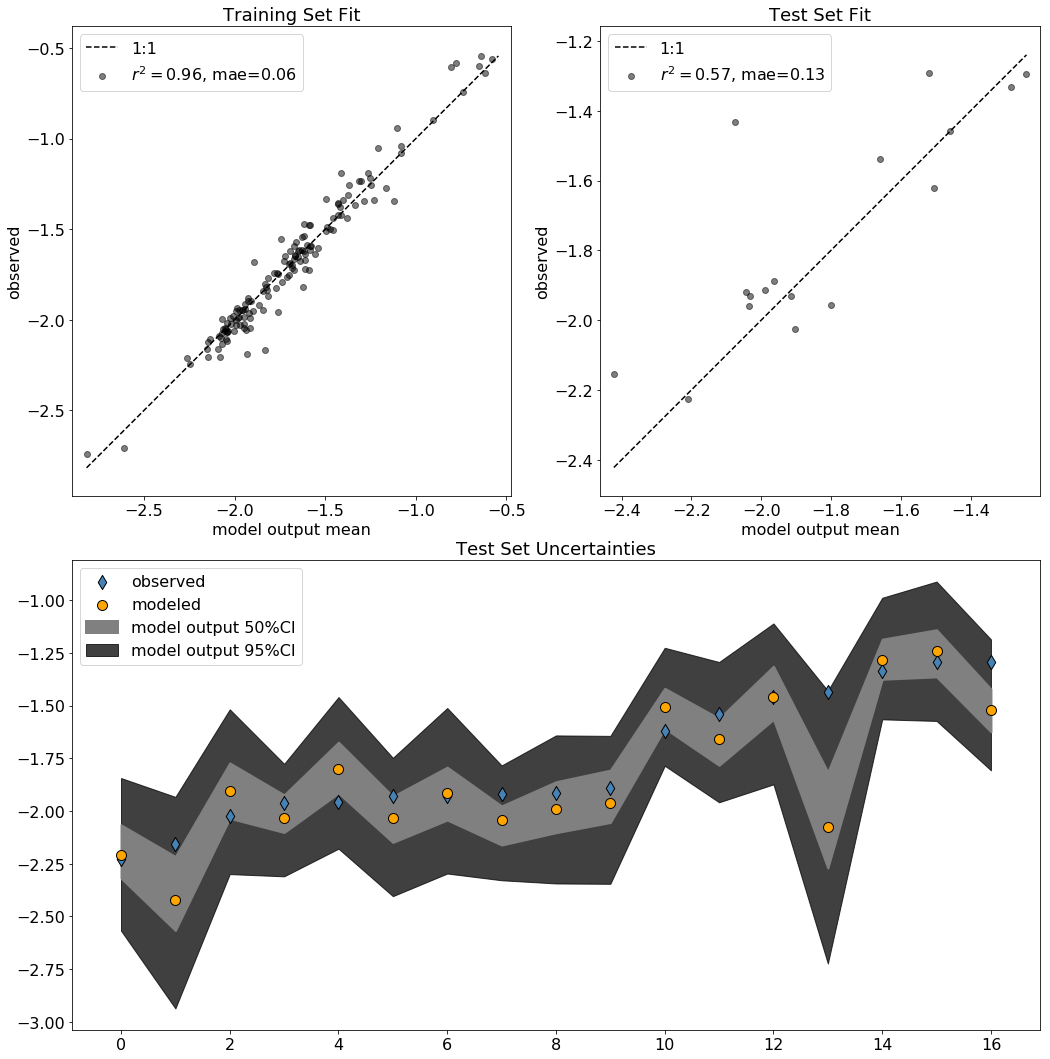

In [22]:
f, ppc_train_489, ppc_test_489 = evaluate_model(m_hshoe_489, y_train.log10_aphy489, y_test.log10_aphy489)
f.get_axes()[0].set_title('Training Set Fit');
f.get_axes()[1].set_title('Test Set Fit');
f.get_axes()[2].set_title('Test Set Uncertainties');

In [23]:
X_shared = shared(X_s_train.values)
m_hshoe_510 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy510, model_name='hshoe_aphy510',
                        ylabel='likelihood', regularized=True)
m_hshoe_510.fit(tune=7000, cores=1, chains=2, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
100%|██████████| 9000/9000 [17:19<00:00,  8.66it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


100%|██████████| 2000/2000 [00:02<00:00, 941.84it/s]


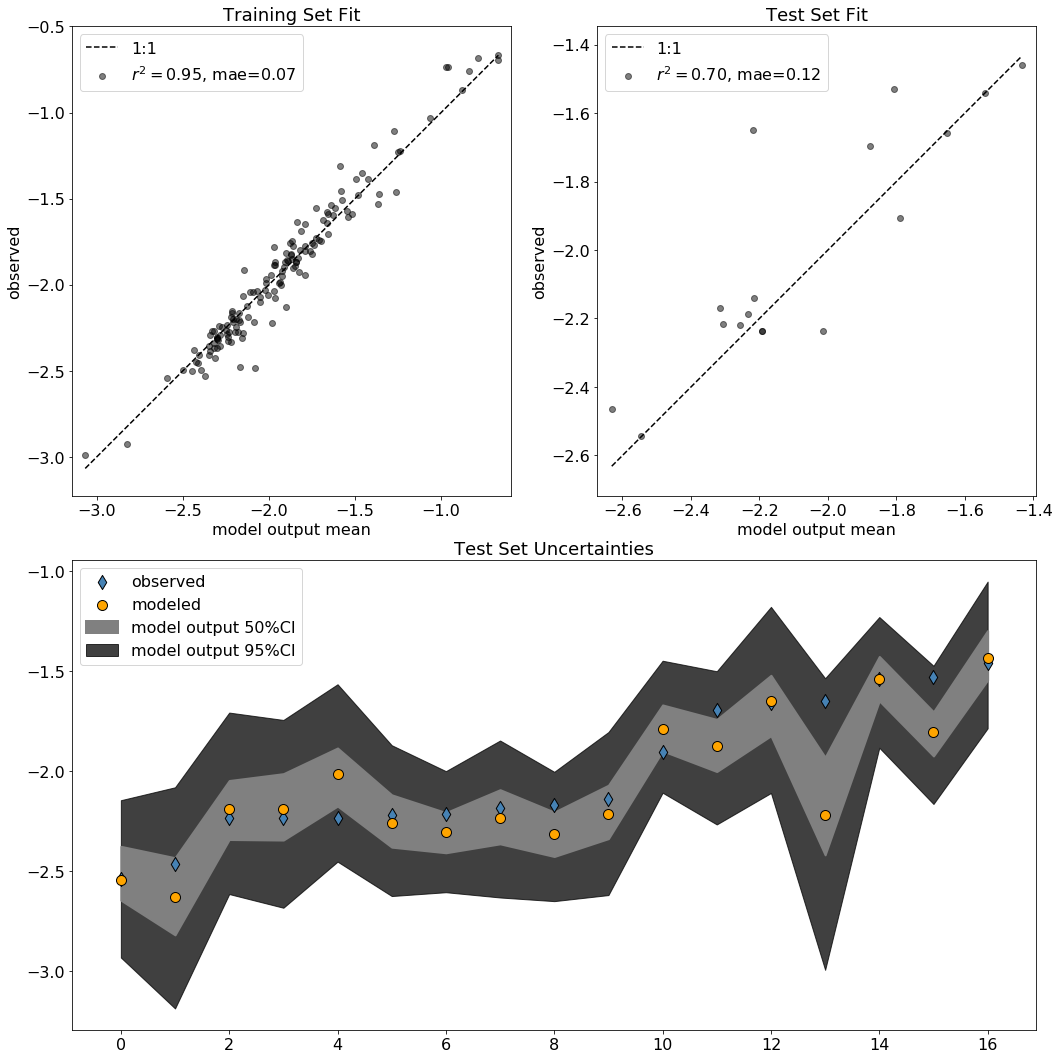

In [24]:
f, ppc_train_510, ppc_test_510 = evaluate_model(m_hshoe_510, y_train.log10_aphy510, y_test.log10_aphy510)
f.get_axes()[0].set_title('Training Set Fit');
f.get_axes()[1].set_title('Test Set Fit');
f.get_axes()[2].set_title('Test Set Uncertainties');

In [26]:
X_shared = shared(X_s_train.values)
m_hshoe_555 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy555, model_name='hshoe_aphy555',
                        ylabel='likelihood', regularized=True)
m_hshoe_555.fit(tune=7000, cores=1,  chains=2, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
100%|██████████| 9000/9000 [15:24<00:00,  9.74it/s] 
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7411006860575453, but should be close to 0.85. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7791141052967876, but should be close to 0.85. Try to increase the number of tuning steps.


100%|██████████| 2000/2000 [00:02<00:00, 918.43it/s]


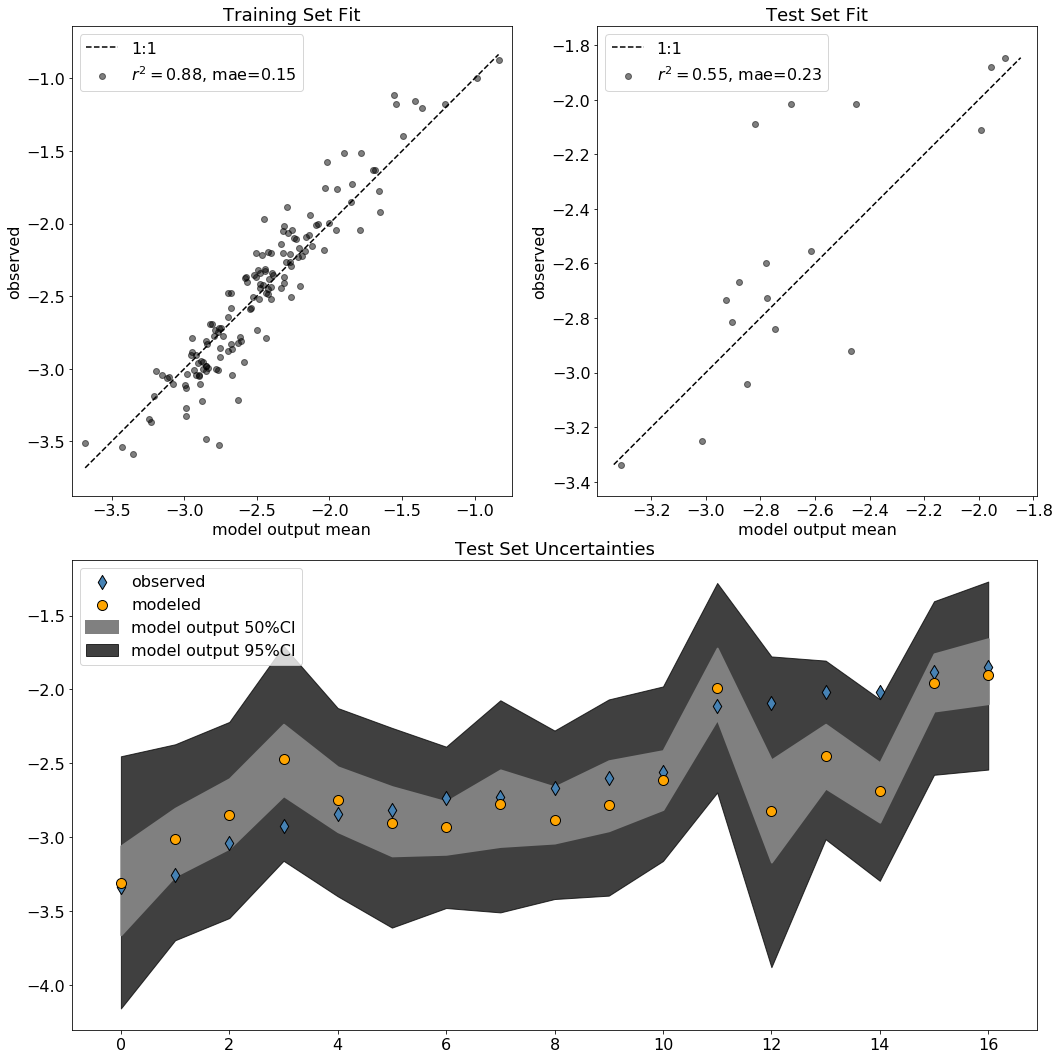

In [27]:
f, ppc_train_555, ppc_test_555 = evaluate_model(m_hshoe_555, y_train.log10_aphy555, y_test.log10_aphy555)
f.get_axes()[0].set_title('Training Set Fit');
f.get_axes()[1].set_title('Test Set Fit');
f.get_axes()[2].set_title('Test Set Uncertainties');

In [28]:
X_shared = shared(X_s_train.values)
m_hshoe_670 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy670, model_name='hshoe_aphy670_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_670.fit(tune=7000, cores=1, chains=2, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
100%|██████████| 9000/9000 [03:21<00:00, 44.71it/s]


100%|██████████| 2000/2000 [00:01<00:00, 1347.31it/s]


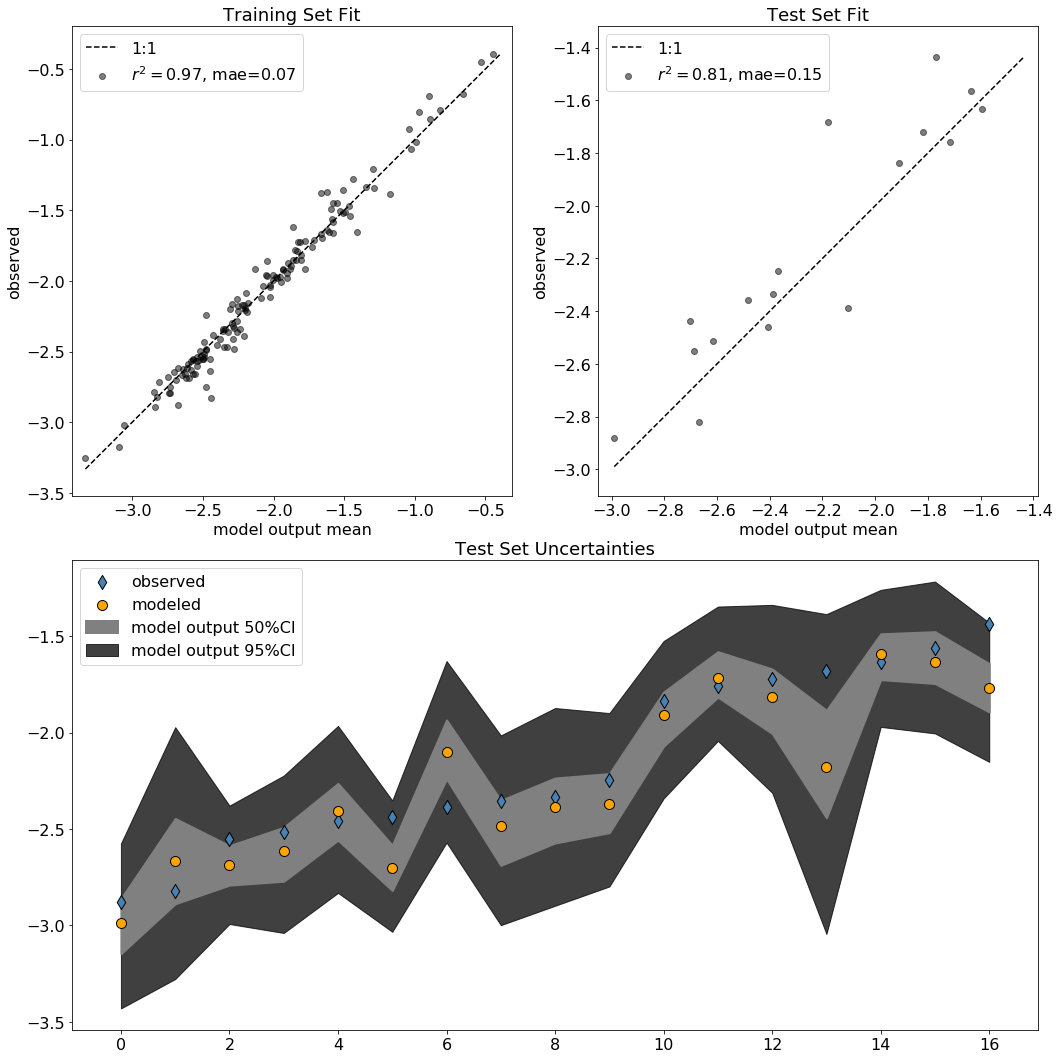

In [29]:
f, ppc_train_670, ppc_test_670 = evaluate_model(m_hshoe_670, y_train.log10_aphy670, y_test.log10_aphy670)
f.get_axes()[0].set_title('Training Set Fit');
f.get_axes()[1].set_title('Test Set Fit');
f.get_axes()[2].set_title('Test Set Uncertainties');

In [34]:
pickleModelDict = {m_hshoe_411.model.name: m_hshoe_411, 
                   m_hshoe_443.model.name: m_hshoe_443,
                   m_hshoe_489.model.name: m_hshoe_489,
                   m_hshoe_510.model.name: m_hshoe_510,
                   m_hshoe_555.model.name: m_hshoe_555,
                   m_hshoe_670.model.name: m_hshoe_670}
with open('./pickleJar/Models/HS_Prior_With_Int_All_APhys.pkl', 'wb') as f:
    pickle.dump(pickleModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)

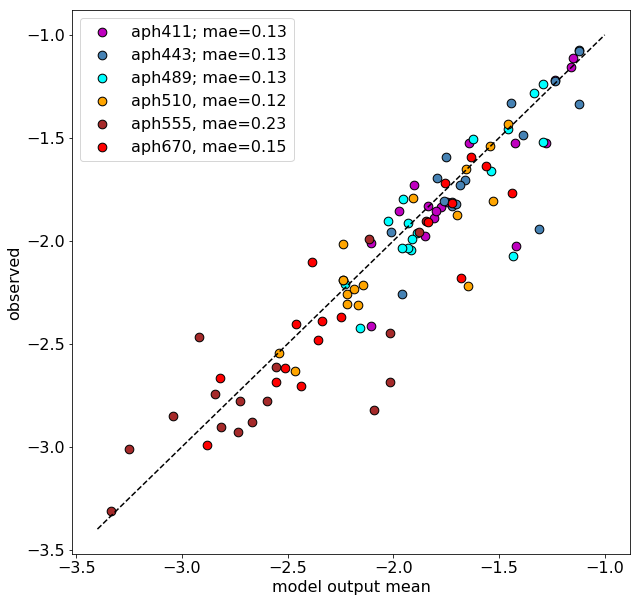

In [33]:
f, ax_ = pl.subplots(figsize=(10, 10))
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, color='m', label='aph411; mae=0.13', s=75, ax=ax_) 
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, color='steelblue', ax=ax_, label='aph443; mae=0.13', s=75,)
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, color='cyan', ax=ax_, label='aph489; mae=0.13', s=75, )
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, color='orange', ax=ax_, label='aph510, mae=0.12', s=75,)
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, color='brown', ax=ax_, label='aph555, mae=0.23', s=75, )
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, color='red', ax=ax_, label='aph670, mae=0.15', s=75, )
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend()
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
f.savefig('./figJar/HorseShoePrior_aphi_test_sets_WithInteractions.pdf', format='pdf', dpi=300)